In [1]:
!pip install --upgrade gym pyvirtualdisplay ipykernel > /dev/null 2>&1

In [19]:
!pip install numpy==1.19.5

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7.3/7.3 MB 44.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  √ó Building wheel for numpy (pyproject.toml) did not run successfully.
  ‚îÇ exit code: 1
  ‚ï∞‚îÄ> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for numpy
Failed to build numpy
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (numpy)


In [22]:
print("NumPy –≤–µ—Ä:", np.__version__)
print("Gym –≤–µ—Ä:", gym.__version__)
print("PyTorch –≤–µ—Ä:", torch.__version__)

NumPy –≤–µ—Ä: 2.0.2
Gym –≤–µ—Ä: 0.26.2
PyTorch –≤–µ—Ä: 2.6.0+cu124


In [47]:
import torch
import gym
import numpy as np
from collections import defaultdict
from IPython import display as ipythondisplay
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [70]:
env = gym.make('MountainCar-v0')

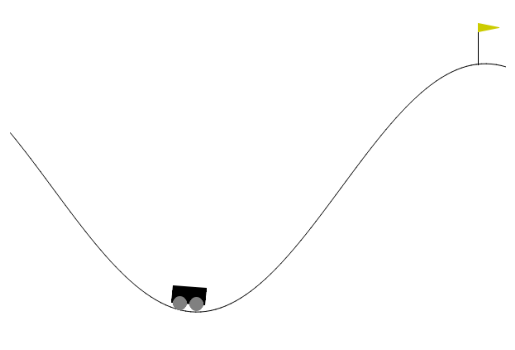

In [147]:
def display(env):
    env.reset()
    img = plt.imshow(env.render())
    plt.axis('off')
    plt.show()
env = gym.make('MountainCar-v0', render_mode="rgb_array")
display(env)
env.close()

In [146]:
state, _ = env.reset()
print(state)

[-0.5812789  0.       ]


In [88]:
for step in range(5):
    action = env.action_space.sample()  # –°–ª—É—á–∞–π–Ω–æ–µ –¥–µ–π—Å—Ç–≤–∏–µ
    state, reward, done, truncated, info = env.step(action)
    print(f"Step {step + 1}: Action={action}, State={state}, Reward={reward}, Done={done}")
    if done or truncated:
        print("Episode finished!")
        break

Step 1: Action=2, State=[-4.2739928e-01  2.9056688e-04], Reward=-1.0, Done=False
Step 2: Action=0, State=[-0.42882022 -0.00142096], Reward=-1.0, Done=False
Step 3: Action=1, State=[-0.43094248 -0.00212226], Reward=-1.0, Done=False
Step 4: Action=1, State=[-0.43375075 -0.00280826], Reward=-1.0, Done=False
Step 5: Action=0, State=[-0.43822473 -0.00447399], Reward=-1.0, Done=False


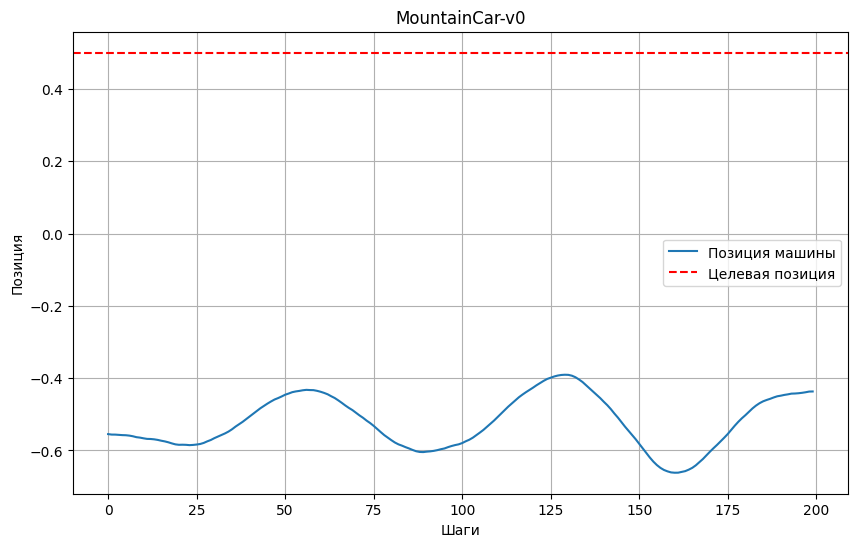

In [149]:
positions = []  # –°–ø–∏—Å–æ–∫ –¥–ª—è —Ö—Ä–∞–Ω–µ–Ω–∏—è –ø–æ–∑–∏—Ü–∏–π –º–∞—à–∏–Ω—ã

# –í—ã–ø–æ–ª–Ω–µ–Ω–∏–µ —ç–ø–∏–∑–æ–¥–∞
done = False
truncated = False
while not (done or truncated):
    action = env.action_space.sample()
    state, reward, done, truncated, info = env.step(action)
    positions.append(state[0])

# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –ø–æ–∑–∏—Ü–∏–π –º–∞—à–∏–Ω—ã
plt.figure(figsize=(10, 6))
plt.plot(positions, label="–ü–æ–∑–∏—Ü–∏—è –º–∞—à–∏–Ω—ã")
plt.axhline(y=0.5, color='r', linestyle='--', label="–¶–µ–ª–µ–≤–∞—è –ø–æ–∑–∏—Ü–∏—è")
plt.title("MountainCar-v0")
plt.xlabel("–®–∞–≥–∏")
plt.ylabel("–ü–æ–∑–∏—Ü–∏—è")
plt.legend()
plt.grid()
plt.show()

# –ó–∞–∫—Ä—ã—Ç–∏–µ —Å—Ä–µ–¥—ã
env.close()

In [179]:
position_bins = np.linspace(-1.2, 0.6, 30)  # –£–≤–µ–ª–∏—á–∏–ª–∏ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –∏–Ω—Ç–µ—Ä–≤–∞–ª–æ–≤
velocity_bins = np.linspace(-0.07, 0.07, 30)
def discretize_state(state):
    position, velocity = state
    position_idx = np.digitize(position, position_bins) - 1
    velocity_idx = np.digitize(velocity, velocity_bins) - 1
    return (position_idx, velocity_idx)

In [180]:
def run_episode(env, Q, epsilon, n_action):
    """
    –í—ã–ø–æ–ª–Ω—è–µ—Ç —ç–ø–∏–∑–æ–¥, —Å–ª–µ–¥—É—è Œµ-–∂–∞–¥–Ω–æ–π —Å—Ç—Ä–∞—Ç–µ–≥–∏–∏
    @param env: –∏–º—è –æ–∫—Ä—É–∂–∞—é—â–µ–π —Å—Ä–µ–¥—ã OpenAI Gym
    @param Q: Q-—Ñ—É–Ω–∫—Ü–∏—è
    @param epsilon: –∫–æ–º–ø—Ä–æ–º–∏—Å—Å –º–µ–∂–¥—É –∏—Å—Å–ª–µ–¥–æ–≤–∞–Ω–∏–µ–º –∏ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º
    @param n_action: –ø—Ä–æ—Å—Ç—Ä–∞–Ω—Å—Ç–≤–æ –¥–µ–π—Å—Ç–≤–∏–π
    @return: —Ä–µ–∑—É–ª—å—Ç–∏—Ä—É—é—â–∏–µ —Å–æ—Å—Ç–æ—è–Ω–∏—è, –¥–µ–π—Å—Ç–≤–∏—è –∏ –≤–æ–∑–Ω–∞–≥—Ä–∞–∂–¥–µ–Ω–∏—è –¥–ª—è –≤—Å–µ–≥–æ —ç–ø–∏–∑–æ–¥–∞
    """
    state, _ = env.reset()  # —Å–±—Ä–æ—Å —Å—Ä–µ–¥—ã –∏ –ø–æ–ª—É—á–µ–Ω–∏–µ –Ω–∞—á–∞–ª—å–Ω–æ–≥–æ —Å–æ—Å—Ç–æ—è–Ω–∏—è
    state = discretize_state(state)
    rewards = []  # —Å–ø–∏—Å–æ–∫ –¥–ª—è —Ö—Ä–∞–Ω–µ–Ω–∏—è –≤–æ–∑–Ω–∞–≥—Ä–∞–∂–¥–µ–Ω–∏–π
    actions = []  # —Å–ø–∏—Å–æ–∫ –¥–ª—è —Ö—Ä–∞–Ω–µ–Ω–∏—è –¥–µ–π—Å—Ç–≤–∏–π
    states = []  # —Å–ø–∏—Å–æ–∫ –¥–ª—è —Ö—Ä–∞–Ω–µ–Ω–∏—è —Å–æ—Å—Ç–æ—è–Ω–∏–π
    while True:
        probs = torch.ones(n_action) * epsilon / n_action
        best_action = torch.argmax(Q[state]).item()
        probs[best_action] += 1.0 - epsilon
        action = torch.multinomial(probs, 1).item()

        actions.append(action)
        states.append(state)

        state, reward, done, truncated, info = env.step(action)
        state = discretize_state(state)
        rewards.append(reward)

        if done or truncated:
            break

    return states, actions, rewards

In [184]:
# –†–µ–∞–ª–∏–∑–∞—Ü–∏—è —É–ø—Ä–∞–≤–ª–µ–Ω–∏—è –ú–ö —Å Œµ-–∂–∞–¥–Ω–æ–π –µ–¥–∏–Ω–æ–π —Å—Ç—Ä–∞—Ç–µ–≥–∏–µ–π
import matplotlib.pyplot as plt

def mc_control_epsilon_greedy(env, gamma, n_episode, epsilon_start, epsilon_end, epsilon_decay):
    """
    –°—Ç—Ä–æ–∏—Ç –æ–ø—Ç–∏–º–∞–ª—å–Ω—É—é Œµ-–∂–∞–¥–Ω—É—é —Å—Ç—Ä–∞—Ç–µ–≥–∏—é –º–µ—Ç–æ–¥–æ–º —É–ø—Ä–∞–≤–ª–µ–Ω–∏—è –ú–ö —Å –µ–¥–∏–Ω–æ–π —Å—Ç—Ä–∞—Ç–µ–≥–∏–µ–π
    @param env: –∏–º—è –æ–∫—Ä—É–∂–∞—é—â–µ–π —Å—Ä–µ–¥—ã OpenAI Gym
    @param gamma: –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç –æ–±–µ—Å—Ü–µ–Ω–∏–≤–∞–Ω–∏—è
    @param n_episode: –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —ç–ø–∏–∑–æ–¥–æ–≤
    @param epsilon: –∫–æ–º–ø—Ä–æ–º–∏—Å—Å –º–µ–∂–¥—É –∏—Å—Å–ª–µ–¥–æ–≤–∞–Ω–∏–µ–º –∏ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º
    @return: –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã–µ Q-—Ñ—É–Ω–∫—Ü–∏—è –∏ —Å—Ç—Ä–∞—Ç–µ–≥–∏—è
    """
    n_action = env.action_space.n  # –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –≤–æ–∑–º–æ–∂–Ω—ã—Ö –¥–µ–π—Å—Ç–≤–∏–π
    G_sum = defaultdict(float)  # —Å—É–º–º–∞ –≤–æ–∑–≤—Ä–∞—Ç–æ–≤ –¥–ª—è –∫–∞–∂–¥–æ–≥–æ —Å–æ—Å—Ç–æ—è–Ω–∏—è-–¥–µ–π—Å—Ç–≤–∏—è
    N = defaultdict(int)  # –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–æ—Å–µ—â–µ–Ω–∏–π –¥–ª—è –∫–∞–∂–¥–æ–≥–æ —Å–æ—Å—Ç–æ—è–Ω–∏—è-–¥–µ–π—Å—Ç–≤–∏—è
    Q = defaultdict(lambda: torch.rand(n_action) * 0.01)  # –∏–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è Q-—Ñ—É–Ω–∫—Ü–∏–∏

    total_rewards = []  # —Å–ø–∏—Å–æ–∫ –¥–ª—è —Ö—Ä–∞–Ω–µ–Ω–∏—è –Ω–∞–≥—Ä–∞–¥ (–ø–æ–±–æ—á–Ω–∞—è –ø–µ—Ä–µ–º–µ–Ω–Ω–∞—è)
    all_positions = []  # —Å–ø–∏—Å–æ–∫ –¥–ª—è —Ö—Ä–∞–Ω–µ–Ω–∏—è –ø–æ–∑–∏—Ü–∏–π –∞–≤—Ç–æ–º–æ–±–∏–ª—è –≤–æ –≤—Å–µ—Ö —ç–ø–∏–∑–æ–¥–∞—Ö

    for episode in range(n_episode):
        epsilon = max(epsilon_end, epsilon_start * (epsilon_decay ** episode))
        states_t, actions_t, rewards_t = run_episode(env, Q, epsilon, n_action)  # –í—ã–ø–æ–ª–Ω–µ–Ω–∏–µ —ç–ø–∏–∑–æ–¥–∞
        return_t = 0  # –∏–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –≤–æ–∑–≤—Ä–∞—Ç–∞ –¥–ª—è —Ç–µ–∫—É—â–µ–≥–æ —ç–ø–∏–∑–æ–¥–∞
        G = {}  # —Å–ª–æ–≤–∞—Ä—å –¥–ª—è —Ö—Ä–∞–Ω–µ–Ω–∏—è –≤–æ–∑–≤—Ä–∞—Ç–æ–≤ –¥–ª—è –∫–∞–∂–¥–æ–≥–æ —Å–æ—Å—Ç–æ—è–Ω–∏—è-–¥–µ–π—Å—Ç–≤–∏—è

        total_reward = sum(rewards_t)  # –æ–±—â–µ–µ –≤–æ–∑–Ω–∞–≥—Ä–∞–∂–¥–µ–Ω–∏–µ –∑–∞ —ç–ø–∏–∑–æ–¥
        total_rewards.append(total_reward)

        # –°–±–æ—Ä –ø–æ–∑–∏—Ü–∏–π –∞–≤—Ç–æ–º–æ–±–∏–ª—è –≤ —Ç–µ–∫—É—â–µ–º —ç–ø–∏–∑–æ–¥–µ
        positions = [state[0] for state in states_t]  # state[0] ‚Äî —ç—Ç–æ –ø–æ–∑–∏—Ü–∏—è –∞–≤—Ç–æ–º–æ–±–∏–ª—è
        all_positions.append(positions)

        # –û–±—Ä–∞—Ç–Ω—ã–π –ø—Ä–æ—Ö–æ–¥ –ø–æ —ç–ø–∏–∑–æ–¥—É –¥–ª—è –≤—ã—á–∏—Å–ª–µ–Ω–∏—è –≤–æ–∑–≤—Ä–∞—Ç–æ–≤
        for state_t, action_t, reward_t in zip(states_t[::-1], actions_t[::-1], rewards_t[::-1]):
            return_t = gamma * return_t + reward_t  # –≤—ã—á–∏—Å–ª–µ–Ω–∏–µ –≤–æ–∑–≤—Ä–∞—Ç–∞ —Å —É—á–µ—Ç–æ–º –æ–±–µ—Å—Ü–µ–Ω–∏–≤–∞–Ω–∏—è
            G[(state_t, action_t)] = return_t  # —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –≤–æ–∑–≤—Ä–∞—Ç–∞ –¥–ª—è —Ç–µ–∫—É—â–µ–≥–æ —Å–æ—Å—Ç–æ—è–Ω–∏—è-–¥–µ–π—Å—Ç–≤–∏—è

        # –û–±–Ω–æ–≤–ª–µ–Ω–∏–µ Q-—Ñ—É–Ω–∫—Ü–∏–∏ –Ω–∞ –æ—Å–Ω–æ–≤–µ –≤–æ–∑–≤—Ä–∞—Ç–æ–≤
        for state_action, return_t in G.items():
            state, action = state_action
            G_sum[state_action] += return_t
            N[state_action] += 1
            alpha = 1 / N[state_action]  # –°–∫–æ—Ä–æ—Å—Ç—å –æ–±—É—á–µ–Ω–∏—è
            Q[state][action] += alpha * (return_t - Q[state][action])

        # –í—ã–≤–æ–¥ –ø—Ä–æ–≥—Ä–µ—Å—Å–∞ –∫–∞–∂–¥—ã–µ 100 —ç–ø–∏–∑–æ–¥–æ–≤
        if (episode + 1) % 100 == 0:
            avg_reward = sum(total_rewards[-100:]) / 100  # —Å—Ä–µ–¥–Ω–µ–µ –≤–æ–∑–Ω–∞–≥—Ä–∞–∂–¥–µ–Ω–∏–µ –∑–∞ –ø–æ—Å–ª–µ–¥–Ω–∏–µ 100 —ç–ø–∏–∑–æ–¥–æ–≤
            print(f"–≠–ø–∏–∑–æ–¥ {episode + 1}/{n_episode}, –°—Ä–µ–¥–Ω–µ–µ –≤–æ–∑–Ω–∞–≥—Ä–∞–∂–¥–µ–Ω–∏–µ –∑–∞ 100 —ç–ø–∏–∑–æ–¥–æ–≤: {avg_reward:.2f}")

    # –§–æ—Ä–º–∏—Ä–æ–≤–∞–Ω–∏–µ –æ–ø—Ç–∏–º–∞–ª—å–Ω–æ–π —Å—Ç—Ä–∞—Ç–µ–≥–∏–∏ –Ω–∞ –æ—Å–Ω–æ–≤–µ Q-—Ñ—É–Ω–∫—Ü–∏–∏
    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()  # –≤—ã–±–æ—Ä –¥–µ–π—Å—Ç–≤–∏—è —Å –º–∞–∫—Å–∏–º–∞–ª—å–Ω—ã–º Q-–∑–Ω–∞—á–µ–Ω–∏–µ–º

    # –ü–æ—Å—Ç—Ä–æ–µ–Ω–∏–µ –≥—Ä–∞—Ñ–∏–∫–∞ –ø–æ–∑–∏—Ü–∏–π
    plot_positions(all_positions)

    return Q, policy  # –≤–æ–∑–≤—Ä–∞—Ç –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã—Ö Q-—Ñ—É–Ω–∫—Ü–∏–∏ –∏ —Å—Ç—Ä–∞—Ç–µ–≥–∏–∏

In [185]:
def plot_positions(all_positions):
    plt.figure(figsize=(12, 6))
    for i, positions in enumerate(all_positions):
        if i % 100 == 0:  # –†–∏—Å—É–µ–º —Ç–æ–ª—å–∫–æ –∫–∞–∂–¥—ã–π 100-–π —ç–ø–∏–∑–æ–¥ –¥–ª—è —á–∏—Ç–∞–µ–º–æ—Å—Ç–∏ –≥—Ä–∞—Ñ–∏–∫–∞
            plt.plot(positions, label=f"–≠–ø–∏–∑–æ–¥ {i + 1}")
    plt.axhline(y=0.5, color='r', linestyle='--', label="–¶–µ–ª—å")  # –õ–∏–Ω–∏—è —Ü–µ–ª–∏
    plt.xlabel("–®–∞–≥–∏")
    plt.ylabel("–ü–æ–∑–∏—Ü–∏—è –∞–≤—Ç–æ–º–æ–±–∏–ª—è")
    plt.title("–ò–∑–º–µ–Ω–µ–Ω–∏–µ –ø–æ–∑–∏—Ü–∏–∏")
    plt.legend()
    plt.show()

In [188]:
gamma = 0.99
n_episode = 50000
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.99

–í–Ω–∏–∑—É –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ, –≤ —Ü–µ–ª–æ–º –ø—Ä–æ–±–ª–µ–º–∞ –∑–∞–∫–ª—é—á–∞–ª–∞—Å—å –≤ —Ç–æ–º —á—Ç–æ –¥–µ–ª–∞—è –ø–æ 10–∫ —ç–ø–∏–∑–æ–¥–æ–≤ –≤—Å–µ–≥–¥–∞ –±—ã–ª–æ –≤ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–µ -200, –∏ —Ä–µ—à–∏–ª –ø–æ—ç–∫—Å–ø–µ—Ä–µ–º–µ–Ω—Ç–∏—Ä–æ–≤–∞—Ç—å —Å –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏, –≤—ã–≤–µ–ª –≥—Ä–∞—Ñ–∏–∫ –¥–ª—è 1000 —ç–ø–∏–∑–æ–¥–æ–≤ –∏ —Å—É–¥—è –ø–æ –ø–æ–∑–∏—Ü–∏–∏, –æ–Ω –≤—Å–µ —Ç–∞–∫–∏ –¥–≤–∏–≥–∞–ª—Å—è.

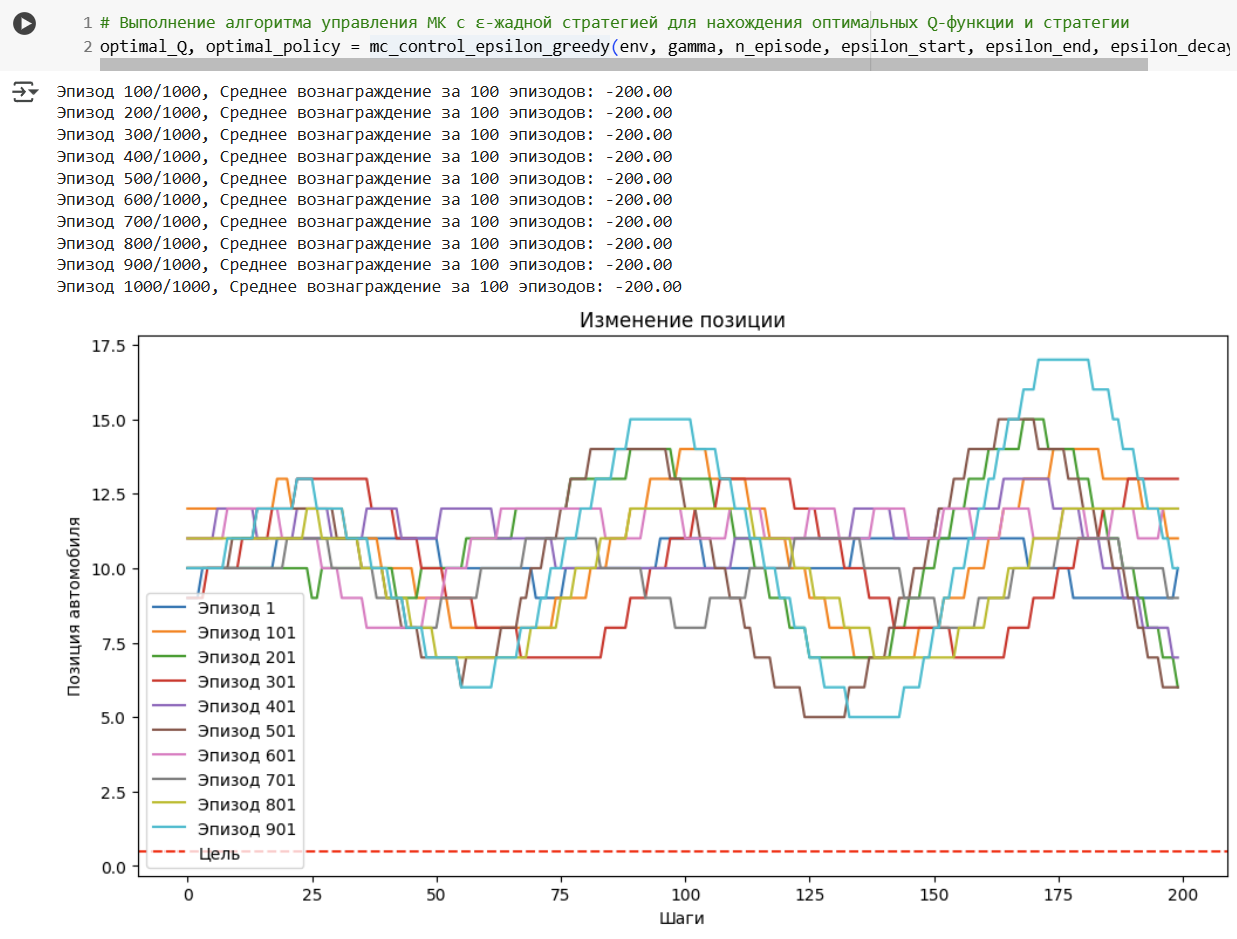

–í–æ—Ç –Ω–∞ –∫–æ–¥–µ –Ω–∏–∂–µ –≤–æ–∑–Ω–∏–∫–∞–ª–∞ –æ—à–∏–±–∫–∞ –ø–æ—Å—Ç–æ—è–Ω–Ω–æ AttributeError: module 'numpy' has no attribute 'bool8'
–ö–∞–∫–∏–º —Ç–æ –º–∞–≥–∏—á–µ—Å–∫–∏–º –æ–±—Ä–∞–∑–æ–º –ø—Ä–∏ –ø–µ—Ä–µ—É—Å—Ç–∞–Ω–æ–≤–∫–µ –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–µ–π –æ–Ω–∞ –ø—Ä–æ–ø–∞–¥–∞–µ—Ç

–≠–ø–∏–∑–æ–¥ 100/50000, –°—Ä–µ–¥–Ω–µ–µ –≤–æ–∑–Ω–∞–≥—Ä–∞–∂–¥–µ–Ω–∏–µ –∑–∞ 100 —ç–ø–∏–∑–æ–¥–æ–≤: -200.00
–≠–ø–∏–∑–æ–¥ 200/50000, –°—Ä–µ–¥–Ω–µ–µ –≤–æ–∑–Ω–∞–≥—Ä–∞–∂–¥–µ–Ω–∏–µ –∑–∞ 100 —ç–ø–∏–∑–æ–¥–æ–≤: -200.00
–≠–ø–∏–∑–æ–¥ 300/50000, –°—Ä–µ–¥–Ω–µ–µ –≤–æ–∑–Ω–∞–≥—Ä–∞–∂–¥–µ–Ω–∏–µ –∑–∞ 100 —ç–ø–∏–∑–æ–¥–æ–≤: -200.00
–≠–ø–∏–∑–æ–¥ 400/50000, –°—Ä–µ–¥–Ω–µ–µ –≤–æ–∑–Ω–∞–≥—Ä–∞–∂–¥–µ–Ω–∏–µ –∑–∞ 100 —ç–ø–∏–∑–æ–¥–æ–≤: -200.00
–≠–ø–∏–∑–æ–¥ 500/50000, –°—Ä–µ–¥–Ω–µ–µ –≤–æ–∑–Ω–∞–≥—Ä–∞–∂–¥–µ–Ω–∏–µ –∑–∞ 100 —ç–ø–∏–∑–æ–¥–æ–≤: -200.00
–≠–ø–∏–∑–æ–¥ 600/50000, –°—Ä–µ–¥–Ω–µ–µ –≤–æ–∑–Ω–∞–≥—Ä–∞–∂–¥–µ–Ω–∏–µ –∑–∞ 100 —ç–ø–∏–∑–æ–¥–æ–≤: -200.00
–≠–ø–∏–∑–æ–¥ 700/50000, –°—Ä–µ–¥–Ω–µ–µ –≤–æ–∑–Ω–∞–≥—Ä–∞–∂–¥–µ–Ω–∏–µ –∑–∞ 100 —ç–ø–∏–∑–æ–¥–æ–≤: -200.00
–≠–ø–∏–∑–æ–¥ 800/50000, –°—Ä–µ–¥–Ω–µ–µ –≤–æ–∑–Ω–∞–≥—Ä–∞–∂–¥–µ–Ω–∏–µ –∑–∞ 100 —ç–ø–∏–∑–æ–¥–æ–≤: -200.00
–≠–ø–∏–∑–æ–¥ 900/50000, –°—Ä–µ–¥–Ω–µ–µ –≤–æ–∑–Ω–∞–≥—Ä–∞–∂–¥–µ–Ω–∏–µ –∑–∞ 100 —ç–ø–∏–∑–æ–¥–æ–≤: -200.00
–≠–ø–∏–∑–æ–¥ 1000/50000, –°—Ä–µ–¥–Ω–µ–µ –≤–æ–∑–Ω–∞–≥—Ä–∞–∂–¥–µ–Ω–∏–µ –∑–∞

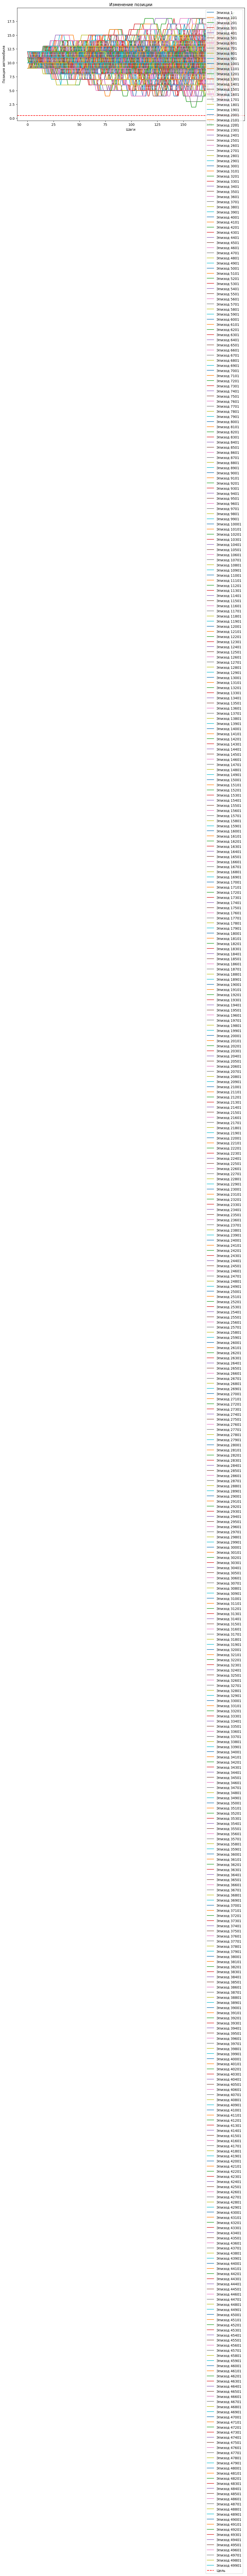

In [189]:
# –í—ã–ø–æ–ª–Ω–µ–Ω–∏–µ –∞–ª–≥–æ—Ä–∏—Ç–º–∞ —É–ø—Ä–∞–≤–ª–µ–Ω–∏—è –ú–ö —Å Œµ-–∂–∞–¥–Ω–æ–π —Å—Ç—Ä–∞—Ç–µ–≥–∏–µ–π –¥–ª—è –Ω–∞—Ö–æ–∂–¥–µ–Ω–∏—è –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã—Ö Q-—Ñ—É–Ω–∫—Ü–∏–∏ –∏ —Å—Ç—Ä–∞—Ç–µ–≥–∏–∏
optimal_Q, optimal_policy = mc_control_epsilon_greedy(env, gamma, n_episode, epsilon_start, epsilon_end, epsilon_decay)

–ò –≤—Å–µ —Ç–∞–∫–∏ –º–∞—à–∏–Ω–∫–∞ –∏—Å—Å–ª–µ–¥—É–µ—Ç –ø—Ä–æ—Å—Ç—Ä–∞–Ω—Å—Ç–≤–æ =)

In [190]:
# –°–Ω–æ–≤–∞ —Å—ã–º–∏—Ç–∏—Ä—É–µ–º 10000 —ç–ø–∏–∑–æ–¥–æ–≤
n_episode = 10000
n_win_optimal = 0
n_lose_optimal = 0

In [193]:
# –û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Ñ—É–Ω–∫—Ü–∏–∏-–æ–±–µ—Ä—Ç–∫–∏, –∫–æ—Ç–æ—Ä–∞—è –≤—ã–ø–æ–ª–Ω—è–µ—Ç –æ–¥–∏–Ω —ç–ø–∏–∑–æ–¥, —Å–ª–µ–¥—É—è –∑–∞–¥–∞–Ω–Ω–æ–π —Å—Ç—Ä–∞—Ç–µ–≥–∏–∏, –∏ –≤–æ–∑–≤—Ä–∞—â–∞–µ—Ç –ø–æ–ª–Ω–æ–µ –≤–æ–∑–Ω–∞–≥—Ä–∞–∂–¥–µ–Ω–∏–µ
def simulate_episode(env, policy):
    state, _ = env.reset()
    state = discretize_state(state)
    total_reward = 0

    while True:
        action = policy[state]
        state, reward, done, truncated, info = env.step(action)
        state = discretize_state(state)
        total_reward += reward

        if done or truncated:
            return total_reward

In [194]:
for _ in range(n_episode):
    reward = simulate_episode(env, optimal_policy)  # –≤—ã–ø–æ–ª–Ω–µ–Ω–∏–µ —ç–ø–∏–∑–æ–¥–∞ —Å –æ–ø—Ç–∏–º–∞–ª—å–Ω–æ–π —Å—Ç—Ä–∞—Ç–µ–≥–∏–µ–π
    if reward == 0:  # MountainCar-v0 –¥–∞–µ—Ç –≤–æ–∑–Ω–∞–≥—Ä–∞–∂–¥–µ–Ω–∏–µ 0 –ø—Ä–∏ –¥–æ—Å—Ç–∏–∂–µ–Ω–∏–∏ —Ü–µ–ª–∏
        n_win_optimal += 1  # —É–≤–µ–ª–∏—á–µ–Ω–∏–µ —Å—á–µ—Ç—á–∏–∫–∞ –≤—ã–∏–≥—Ä—ã—à–µ–π
    elif reward < 0:  # –ï—Å–ª–∏ —Ü–µ–ª—å –Ω–µ –¥–æ—Å—Ç–∏–≥–Ω—É—Ç–∞, –≤–æ–∑–Ω–∞–≥—Ä–∞–∂–¥–µ–Ω–∏–µ –æ—Ç—Ä–∏—Ü–∞—Ç–µ–ª—å–Ω–æ–µ
        n_lose_optimal += 1  # —É–≤–µ–ª–∏—á–µ–Ω–∏–µ —Å—á–µ—Ç—á–∏–∫–∞ –ø—Ä–æ–∏–≥—Ä—ã—à–µ–π

# –í—ã–≤–æ–¥ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
print('–í–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å –≤—ã–∏–≥—Ä—ã—à–∞ –ø—Ä–∏ –æ–ø—Ç–∏–º–∞–ª—å–Ω–æ–π —Å—Ç—Ä–∞—Ç–µ–≥–∏–∏: {}'.format(n_win_optimal / n_episode))
print('–í–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å –ø—Ä–æ–∏–≥—Ä—ã—à–∞ –ø—Ä–∏ –æ–ø—Ç–∏–º–∞–ª—å–Ω–æ–π —Å—Ç—Ä–∞—Ç–µ–≥–∏–∏: {}'.format(n_lose_optimal / n_episode))

–í–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å –≤—ã–∏–≥—Ä—ã—à–∞ –ø—Ä–∏ –æ–ø—Ç–∏–º–∞–ª—å–Ω–æ–π —Å—Ç—Ä–∞—Ç–µ–≥–∏–∏: 0.0
–í–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å –ø—Ä–æ–∏–≥—Ä—ã—à–∞ –ø—Ä–∏ –æ–ø—Ç–∏–º–∞–ª—å–Ω–æ–π —Å—Ç—Ä–∞—Ç–µ–≥–∏–∏: 1.0


–í —Ü–µ–ª–æ–º –æ–Ω–æ –∏ –ª–æ–≥–∏—á–Ω–æ, –≤–µ–¥—å –∑–∞ 50–∫ —ç–ø–∏–∑–æ–¥–æ–≤ –æ–Ω–∞ —Ç–∞–∫ –∏ –Ω–µ —Å–º–æ–≥–ª–∞ –¥–æ–π—Ç–∏ –¥–æ —Ñ–∏–Ω–∏—à–∞, —Ö–æ—Ç—è –≤ –Ω–µ–∫–æ—Ç–æ—Ä—ã—Ö –∏–∑ –Ω–∏—Ö –±—ã–ª–∞ –æ—á–µ–Ω—å –±–ª–∏–∑–∫–∞.

In [212]:
from mpl_toolkits.mplot3d import Axes3D
def plot_mountaincar_value(Q, policy=None):

    # –î–∏–∞–ø–∞–∑–æ–Ω –ø–æ–∑–∏—Ü–∏–π –∞–≤—Ç–æ–º–æ–±–∏–ª—è (–æ—Ç -1.2 –¥–æ 0.6)
    position_range = np.linspace(-1.2, 0.6, 50)

    # –î–∏–∞–ø–∞–∑–æ–Ω —Å–∫–æ—Ä–æ—Å—Ç–µ–π –∞–≤—Ç–æ–º–æ–±–∏–ª—è (–æ—Ç -0.07 –¥–æ 0.07)
    velocity_range = np.linspace(-0.07, 0.07, 50)

    # –°–æ–∑–¥–∞–Ω–∏–µ —Å–µ—Ç–∫–∏ –¥–ª—è –æ—Å–µ–π X –∏ Y
    X, Y = np.meshgrid(position_range, velocity_range)

    # –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –º–∞—Å—Å–∏–≤–∞ –¥–ª—è —Ö—Ä–∞–Ω–µ–Ω–∏—è –∑–Ω–∞—á–µ–Ω–∏–π —Ü–µ–Ω–Ω–æ—Å—Ç–∏
    values_to_plot = np.zeros_like(X)

    for i in range(len(position_range)):
        for j in range(len(velocity_range)):
            state = (float(position_range[i]), float(velocity_range[j]))  # –ü—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ –≤ –∫–æ—Ä—Ç–µ–∂ —Å float
            if state in Q:
                if policy is None:
                    values_to_plot[j, i] = max(Q[state])
                else:
                    action = policy.get(state, 0)
                    values_to_plot[j, i] = Q[state][action]
            else:
                values_to_plot[j, i] = 0

    # –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è —Ñ—É–Ω–∫—Ü–∏–∏ —Ü–µ–Ω–Ω–æ—Å—Ç–∏
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, values_to_plot, cmap='viridis')

    # –ù–∞—Å—Ç—Ä–æ–π–∫–∞ –º–µ—Ç–æ–∫ –æ—Å–µ–π
    ax.set_xlabel("–ü–æ–∑–∏—Ü–∏—è")
    ax.set_ylabel("–°–∫–æ—Ä–æ—Å—Ç—å")
    ax.set_zlabel("–¶–µ–Ω–Ω–æ—Å—Ç—å")
    ax.set_title("–§—É–Ω–∫—Ü–∏—è —Ü–µ–Ω–Ω–æ—Å—Ç–∏")

    plt.show()

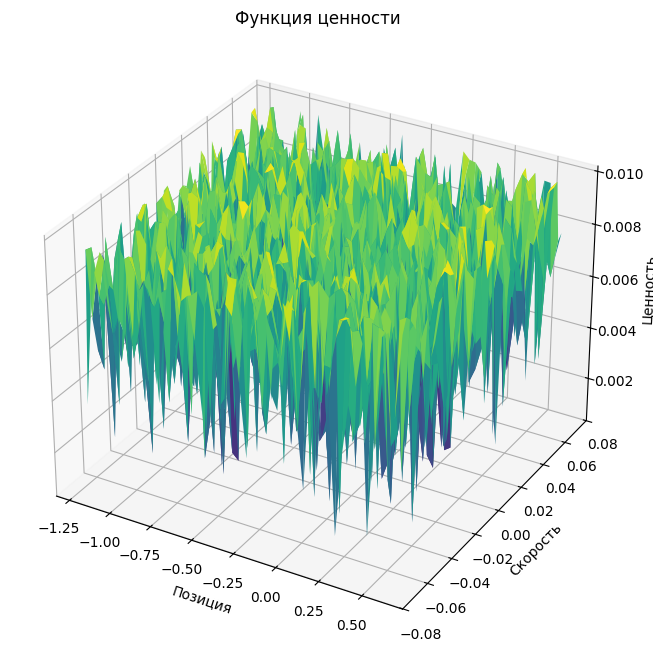

In [213]:
plot_mountaincar_value(optimal_Q)

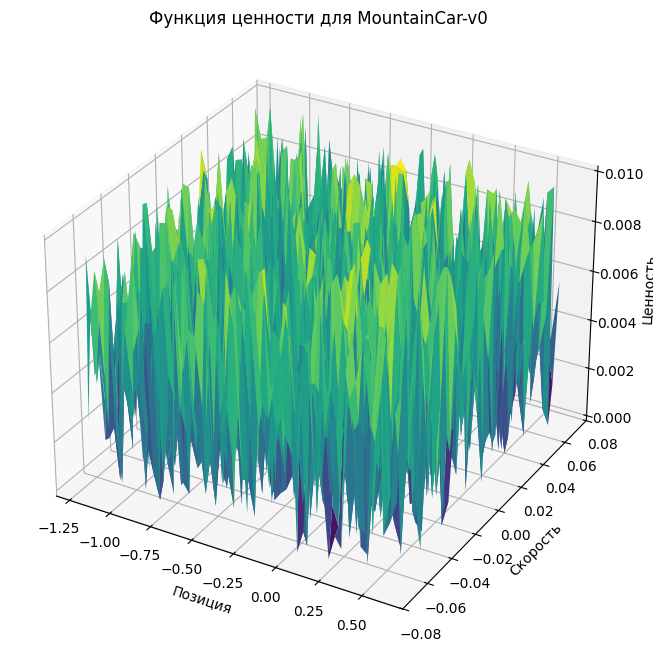

In [211]:
# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –∑–Ω–∞—á–µ–Ω–∏–π V-—Ñ—É–Ω–∫—Ü–∏–∏ –¥–ª—è –æ–ø—Ç–∏–º–∞–ª—å–Ω–æ–π —Å—Ç—Ä–∞—Ç–µ–≥–∏–∏
plot_mountaincar_value(optimal_Q, optimal_policy)

–í—ã–≤–æ–¥: –æ–±—É—á–µ–Ω–∏–µ —Å –ø–æ–º–æ—â—å—é –∞–ª–≥–æ—Ä–∏—Ç–º–∞ –ú–ö —Å Œµ-–∂–∞–¥–Ω–æ–π —Å—Ç—Ä–∞—Ç–µ–≥–∏–µ–π –¥–ª—è –¥–∞–Ω–Ω–æ–≥–æ —Å–ª—É—á–∞—è –≤—Ä—è–¥ –ª–∏ –º–æ–∂–Ω–æ –Ω–∞–∑–≤–∞—Ç—å –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã–º, —Ç.–∫ –∞–≥–µ–Ω—Ç –¥–æ–ª–≥–æ –∏—Å—Å–ª–µ–¥—É–µ—Ç –ø—Ä–æ—Å—Ç—Ä–∞–Ω—Å—Ç–≤–æ, —Å–∫–æ—Ä–µ–π –≤—Å–µ–≥–æ –∏–∑-–∑–∞ –≤–Ω–µ—Å–µ–Ω–∏—è "—Å–ª—É—á–∞–π–Ω–æ–≥–æ –¥–µ–π—Å—Ç–≤–∏—è" –≤ –µ–≥–æ –∞–∫—Ç–∏–≤–Ω–æ—Å—Ç—å. –°—É–¥—è –ø–æ –≥—Ä–∞—Ñ–∏–∫–∞–º, –º–æ–∂–Ω–æ –ø—Ä–µ–¥—Å—Ç–∞–≤–∏—Ç—å –∫–∞—Ä—Ç–∏–Ω—É, —á—Ç–æ –≤ –Ω–∞—à–µ–º —Å–ª—É—á–∞–µ –º–∞—à–∏–Ω–∫–∞ –ø—Ä–æ—Å—Ç–æ –∫–∞—Ç–∞–µ—Ç—Å—è –≤–∑–∞–¥-–≤–ø–µ—Ä–µ–¥, –ø–æ—Å—Ç–µ–ø–µ–Ω–Ω–æ –∏–∑—É—á–∞—è –º–µ—Å—Ç–Ω–æ—Å—Ç—å, –ø–æ–∫–∞ –Ω–µ –¥–æ–π–¥–µ—Ç –¥–æ –ø–∏–∫–æ–≤–æ–π —Ç–æ—á–∫–∏ —Å–ª–µ–≤–∞ –ª–∏–±–æ –¥–æ —Ñ–∏–Ω–∏—à–∞ —Å–ø—Ä–∞–≤–∞. –ü–æ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞–º 50–∫ —ç–ø–∏–∑–æ–¥–æ–≤ –æ–Ω–∞ —Ç–∞–∫ –∏ –Ω–µ —Å–º–æ–≥–ª–∞ –¥–æ—Å—Ç–∏—á—å —Ñ–∏–Ω–∏—à–∞, –Ω–æ –±—ã–ª–∞ –ø—Ä–µ–¥–µ–ª—å–Ω–æ –±–ª–∏–∑–∫–∞ –∫ –Ω–µ–º—É. –ü–æ—ç—Ç–æ–º—É —Å —É–≤–µ—Ä–µ–Ω–Ω–æ—Å—Ç—å—é –º–æ–∂–Ω–æ —Å–∫–∞–∑–∞—Ç—å, —á—Ç–æ —É–≤–µ–ª–∏—á–µ–Ω–∏–µ —ç–ø–∏–∑–æ–¥–æ–≤ —Å–æ –≤—Ä–µ–º–µ–Ω–µ–º –ø–æ–∑–≤–æ–ª–∏–ª–æ –±—ã –∞–≥–µ–Ω—Ç—É –¥–æ—Å—Ç–∏—á—å —Ñ–∏–Ω–∏—à–∞. üòÄ